⏳ Mounting Drive & Loading Models...
Mounted at /content/drive
✅ AI Models Loaded!
🔄 initializing Object Detector...
⬇️ Downloading MobileNetSSD_deploy.prototxt.txt...
⬇️ Downloading MobileNetSSD_deploy.caffemodel...
✅ Smart Crop Ready!


Saving Black-labrador-retriever-dog.webp to Black-labrador-retriever-dog.webp


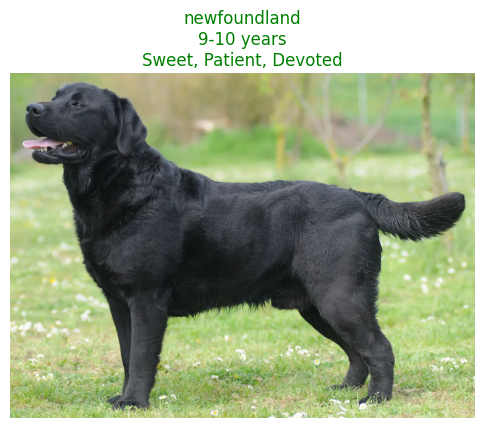

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
import cv2
import os
import urllib.request

# --- 1. LOAD AI MODELS ---
print("⏳ Mounting Drive & Loading Models...")
drive.mount('/content/drive')
folder = "/content/drive/MyDrive/Dog_Project_Models"

try:
    models = {
        'resnet50': keras.models.load_model(f"{folder}/resnet50_dogs.keras"),
        'efficientnetb0': keras.models.load_model(f"{folder}/efficientnetb0_dogs.keras"),
        'mobilenetv2': keras.models.load_model(f"{folder}/mobilenetv2_dogs.keras")
    }
    mlp = keras.models.load_model(f"{folder}/mlp_ensemble.keras")
    print("✅ AI Models Loaded!")
except OSError:
    print("❌ Error: Could not find models. Check your Drive folder.")

# --- 2. DOWNLOAD OPENCV (The Fix) ---
print("🔄 initializing Object Detector...")
files_needed = {
    "MobileNetSSD_deploy.prototxt.txt": "https://raw.githubusercontent.com/djmv/MobilNet_SSD_opencv/master/MobileNetSSD_deploy.prototxt",
    "MobileNetSSD_deploy.caffemodel": "https://raw.githubusercontent.com/djmv/MobilNet_SSD_opencv/master/MobileNetSSD_deploy.caffemodel"
}

for fname, url in files_needed.items():
    if os.path.exists(fname) and os.path.getsize(fname) < 2000:
        os.remove(fname) # Clean broken files
    if not os.path.exists(fname):
        print(f"⬇️ Downloading {fname}...")
        try:
            urllib.request.urlretrieve(url, fname)
        except:
            print(f"❌ Failed to download {fname}")

try:
    net = cv2.dnn.readNetFromCaffe("MobileNetSSD_deploy.prototxt.txt", "MobileNetSSD_deploy.caffemodel")
    print("✅ Smart Crop Ready!")
except:
    print("⚠️ Smart Crop Disabled (Model missing)")
    net = None

# --- 3. BREED DATA ---
breed_info = {
    'american_bulldog': {'life': '10-12 years', 'traits': 'Confident, Social, Active'},
    'american_pit_bull_terrier': {'life': '8-15 years', 'traits': 'Loyal, Courageous, Friendly'},
    'basset_hound': {'life': '12-13 years', 'traits': 'Patient, Low-energy, Charming'},
    'beagle': {'life': '10-15 years', 'traits': 'Curious, Merry, Friendly'},
    'boxer': {'life': '10-12 years', 'traits': 'Bright, Fun-loving, Active'},
    'chihuahua': {'life': '14-16 years', 'traits': 'Charming, Graceful, Sassy'},
    'english_cocker_spaniel': {'life': '12-14 years', 'traits': 'Merry, Responsive, Gentle'},
    'english_setter': {'life': '12 years', 'traits': 'Friendly, Mellow, Merry'},
    'german_shorthaired': {'life': '10-12 years', 'traits': 'Friendly, Smart, Willing to Please'},
    'great_pyrenees': {'life': '10-12 years', 'traits': 'Smart, Patient, Calm'},
    'havanese': {'life': '14-16 years', 'traits': 'Funny, Intelligent, Outgoing'},
    'japanese_chin': {'life': '10-12 years', 'traits': 'Charming, Noble, Loving'},
    'keeshond': {'life': '12-15 years', 'traits': 'Friendly, Lively, Outgoing'},
    'leonberger': {'life': '7 years', 'traits': 'Gentle, Friendly, Playful'},
    'miniature_pinscher': {'life': '12-16 years', 'traits': 'Fearless, Spirited, Proud'},
    'newfoundland': {'life': '9-10 years', 'traits': 'Sweet, Patient, Devoted'},
    'pomeranian': {'life': '12-16 years', 'traits': 'Lively, Bold, Inquisitive'},
    'pug': {'life': '13-15 years', 'traits': 'Loving, Charming, Mischievous'},
    'saint_bernard': {'life': '8-10 years', 'traits': 'Playful, Charming, Inquisitive'},
    'samoyed': {'life': '12-14 years', 'traits': 'Adaptable, Friendly, Gentle'},
    'scottish_terrier': {'life': '12 years', 'traits': 'Independent, Confident, Spirited'},
    'shiba_inu': {'life': '13-16 years', 'traits': 'Alert, Active, Attentive'},
    'staffordshire_bull_terrier': {'life': '12-14 years', 'traits': 'Clever, Brave, Tenacious'},
    'wheaten_terrier': {'life': '12-14 years', 'traits': 'Happy, Steady, Self-Confident'},
    'yorkshire_terrier': {'life': '11-15 years', 'traits': 'Sprightly, Tomboyish, Affectionate'}
}

# Names Setup
cat_breeds = {"Abyssinian","Bengal","Birman","Bombay","British_Shorthair","Egyptian_Mau",
              "Maine_Coon","Persian","Ragdoll","Russian_Blue","Siamese","Sphynx"}
info = tfds.builder("oxford_iiit_pet").info
dog_names = [n for n in info.features["label"].names if n not in cat_breeds]

# --- 4. PREDICT FUNCTION ---
def get_dog_roi(img_path):
    img = cv2.imread(img_path)
    if img is None: return None, False
    if net is None: return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), False

    (h, w) = img.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 0.007843, (300, 300), 127.5)
    net.setInput(blob)
    detections = net.forward()

    best_conf = 0.0
    dog_box = None
    for i in range(detections.shape[2]):
        conf = detections[0, 0, i, 2]
        if int(detections[0, 0, i, 1]) == 12 and conf > 0.2:
            if conf > best_conf:
                best_conf = conf
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                dog_box = box.astype("int")

    if dog_box is not None:
        (sx, sy, ex, ey) = dog_box
        sx = max(0, sx-20); sy = max(0, sy-20)
        ex = min(w, ex+20); ey = min(h, ey+20)
        return cv2.cvtColor(img[sy:ey, sx:ex], cv2.COLOR_BGR2RGB), True
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), False

def predict_deployment():
    uploaded = files.upload()
    for filename in uploaded.keys():
        roi, cropped = get_dog_roi(filename)
        if roi is None: continue

        img_r = cv2.resize(roi, (224, 224))
        img_arr = np.expand_dims(img_r, axis=0) / 255.0

        p1 = models['resnet50'].predict(img_arr, verbose=0)
        p2 = models['efficientnetb0'].predict(img_arr, verbose=0)
        p3 = models['mobilenetv2'].predict(img_arr, verbose=0)

        final = mlp.predict(np.concatenate([p1, p2, p3], axis=1), verbose=0)
        idx = np.argmax(final)
        conf = np.max(final) * 100
        breed = dog_names[idx]
        info = breed_info.get(breed, {'life': '?', 'traits': '?'})

        plt.figure(figsize=(6,6))
        plt.imshow(roi)
        title = f"{breed}\n{info['life']}\n{info['traits']}" if conf > 50 else "Uncertain"
        plt.title(title, color="green" if conf > 50 else "red")
        plt.axis("off")
        plt.show()

predict_deployment()

In [ ]:
import shutil
from google.colab import files
from google.colab import drive
import os

# 1. Mount Drive to find the files
drive.mount('/content/drive')
source_folder = "/content/drive/MyDrive/Dog_Project_Models"

# 2. Check if files exist
if os.path.exists(source_folder):
    print("⏳ Zipping your models... (This might take a minute)")

    # 3. Create a ZIP file of the entire folder
    shutil.make_archive("/content/Dog_Models_Backup", 'zip', source_folder)

    # 4. Trigger the Download
    print("⬇️ Download starting! Check your browser's download bar.")
    files.download("/content/Dog_Models_Backup.zip")
else:
    print("⚠️ Error: Could not find the 'Dog_Project_Models' folder in your Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⏳ Zipping your models... (This might take a minute)
⬇️ Download starting! Check your browser's download bar.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

pip install tensorflow opencv-python matplotlib tensorflow-datasets
python dog_app.py

In [ ]:
#unzip ur folder and run it
#change the model folder path


import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tkinter as tk
from tkinter import filedialog
import cv2
import os
import urllib.request

# ==========================================
# 🛑 CONFIGURATION: UPDATE THIS PATH!
# ==========================================
# Point this to the folder where you unzipped your models.
# Windows Example: r"C:\Users\John\Downloads\Dog_Models_Backup"
MODEL_FOLDER = r"C:\Users\YourName\Downloads\Dog_Models_Backup"
# ==========================================

print(f"🚀 Starting Dog App...")
print(f"📂 Looking for models in: {MODEL_FOLDER}")

# --- 1. ROBUST DOWNLOAD (OpenCV Tools) ---
files_needed = {
    "MobileNetSSD_deploy.prototxt.txt": "https://raw.githubusercontent.com/djmv/MobilNet_SSD_opencv/master/MobileNetSSD_deploy.prototxt",
    "MobileNetSSD_deploy.caffemodel": "https://raw.githubusercontent.com/djmv/MobilNet_SSD_opencv/master/MobileNetSSD_deploy.caffemodel"
}

print("Checking OpenCV files...")
for fname, url in files_needed.items():
    if os.path.exists(fname) and os.path.getsize(fname) < 2000:
        os.remove(fname) # Delete if broken

    if not os.path.exists(fname):
        print(f"⬇️ Downloading {fname}...")
        try:
            urllib.request.urlretrieve(url, fname)
        except Exception as e:
            print(f"❌ Download failed: {e}")

try:
    net = cv2.dnn.readNetFromCaffe("MobileNetSSD_deploy.prototxt.txt", "MobileNetSSD_deploy.caffemodel")
    print("✅ OpenCV Object Detector Ready!")
except:
    print("⚠️ OpenCV Failed. Smart Crop disabled.")
    net = None

# --- 2. LOAD MODELS FROM FOLDER ---
print("⏳ Loading AI Models (This may take a moment)...")
try:
    models = {
        'resnet50': keras.models.load_model(os.path.join(MODEL_FOLDER, "resnet50_dogs.keras")),
        'efficientnetb0': keras.models.load_model(os.path.join(MODEL_FOLDER, "efficientnetb0_dogs.keras")),
        'mobilenetv2': keras.models.load_model(os.path.join(MODEL_FOLDER, "mobilenetv2_dogs.keras"))
    }
    mlp = keras.models.load_model(os.path.join(MODEL_FOLDER, "mlp_ensemble.keras"))
    print("✅ All Models Loaded Successfully!")
except OSError as e:
    print(f"\n❌ CRITICAL ERROR: Could not find models.")
    print(f"Checked path: {MODEL_FOLDER}")
    print("👉 Please edit the 'MODEL_FOLDER' line in the script to match your unzipped folder location.")
    exit()

# --- 3. BREED DATA ---
breed_info = {
    'american_bulldog': {'life': '10-12 years', 'traits': 'Confident, Social, Active'},
    'american_pit_bull_terrier': {'life': '8-15 years', 'traits': 'Loyal, Courageous, Friendly'},
    'basset_hound': {'life': '12-13 years', 'traits': 'Patient, Low-energy, Charming'},
    'beagle': {'life': '10-15 years', 'traits': 'Curious, Merry, Friendly'},
    'boxer': {'life': '10-12 years', 'traits': 'Bright, Fun-loving, Active'},
    'chihuahua': {'life': '14-16 years', 'traits': 'Charming, Graceful, Sassy'},
    'english_cocker_spaniel': {'life': '12-14 years', 'traits': 'Merry, Responsive, Gentle'},
    'english_setter': {'life': '12 years', 'traits': 'Friendly, Mellow, Merry'},
    'german_shorthaired': {'life': '10-12 years', 'traits': 'Friendly, Smart, Willing to Please'},
    'great_pyrenees': {'life': '10-12 years', 'traits': 'Smart, Patient, Calm'},
    'havanese': {'life': '14-16 years', 'traits': 'Funny, Intelligent, Outgoing'},
    'japanese_chin': {'life': '10-12 years', 'traits': 'Charming, Noble, Loving'},
    'keeshond': {'life': '12-15 years', 'traits': 'Friendly, Lively, Outgoing'},
    'leonberger': {'life': '7 years', 'traits': 'Gentle, Friendly, Playful'},
    'miniature_pinscher': {'life': '12-16 years', 'traits': 'Fearless, Spirited, Proud'},
    'newfoundland': {'life': '9-10 years', 'traits': 'Sweet, Patient, Devoted'},
    'pomeranian': {'life': '12-16 years', 'traits': 'Lively, Bold, Inquisitive'},
    'pug': {'life': '13-15 years', 'traits': 'Loving, Charming, Mischievous'},
    'saint_bernard': {'life': '8-10 years', 'traits': 'Playful, Charming, Inquisitive'},
    'samoyed': {'life': '12-14 years', 'traits': 'Adaptable, Friendly, Gentle'},
    'scottish_terrier': {'life': '12 years', 'traits': 'Independent, Confident, Spirited'},
    'shiba_inu': {'life': '13-16 years', 'traits': 'Alert, Active, Attentive'},
    'staffordshire_bull_terrier': {'life': '12-14 years', 'traits': 'Clever, Brave, Tenacious'},
    'wheaten_terrier': {'life': '12-14 years', 'traits': 'Happy, Steady, Self-Confident'},
    'yorkshire_terrier': {'life': '11-15 years', 'traits': 'Sprightly, Tomboyish, Affectionate'}
}

# Names
print("⏳ Fetching breed list...")
cat_breeds = {"Abyssinian","Bengal","Birman","Bombay","British_Shorthair","Egyptian_Mau",
              "Maine_Coon","Persian","Ragdoll","Russian_Blue","Siamese","Sphynx"}
info = tfds.builder("oxford_iiit_pet").info
dog_names = [n for n in info.features["label"].names if n not in cat_breeds]

# --- 4. PREDICT APP ---
def get_dog_roi(img_path):
    img = cv2.imread(img_path)
    if img is None: return None, False
    if net is None: return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), False

    (h, w) = img.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 0.007843, (300, 300), 127.5)
    net.setInput(blob)
    detections = net.forward()

    best_conf = 0.0
    dog_box = None
    for i in range(detections.shape[2]):
        conf = detections[0, 0, i, 2]
        if int(detections[0, 0, i, 1]) == 12 and conf > 0.2:
            if conf > best_conf:
                best_conf = conf
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                dog_box = box.astype("int")
    if dog_box is not None:
        (sx, sy, ex, ey) = dog_box
        sx, sy = max(0, sx-20), max(0, sy-20)
        ex, ey = min(w, ex+20), min(h, ey+20)
        return cv2.cvtColor(img[sy:ey, sx:ex], cv2.COLOR_BGR2RGB), True
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), False

def run_app():
    print("\n📸 Opening File Selector...")
    root = tk.Tk()
    root.withdraw()
    filename = filedialog.askopenfilename(title="Select a Dog Image", filetypes=[("Image files", "*.jpg *.jpeg *.png")])

    if filename:
        print(f"Processing: {filename}")
        roi, cropped = get_dog_roi(filename)
        if roi is None:
            print("Error: Could not read image.")
            return

        img_r = cv2.resize(roi, (224, 224))
        img_arr = np.expand_dims(img_r, axis=0) / 255.0

        p1 = models['resnet50'].predict(img_arr, verbose=0)
        p2 = models['efficientnetb0'].predict(img_arr, verbose=0)
        p3 = models['mobilenetv2'].predict(img_arr, verbose=0)
        final = mlp.predict(np.concatenate([p1, p2, p3], axis=1), verbose=0)

        idx = np.argmax(final)
        conf = np.max(final) * 100
        breed = dog_names[idx]
        info = breed_info.get(breed, {'life': 'Unknown', 'traits': 'Unknown'})

        plt.figure(figsize=(6,6))
        plt.imshow(roi)
        title = f"{breed}\n{info['life']}\n{info['traits']}" if conf > 50 else "Uncertain"
        plt.title(title, color="green" if conf > 50 else "red")
        plt.axis("off")
        plt.show()
        print("✅ Done! Check the popup window.")
    else:
        print("❌ No file selected.")

if __name__ == "__main__":
    run_app()